In [71]:
import sys
from pathlib import Path

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from src.visualization import tensor_to_image
from skimage.color import gray2rgb
from torchvision.ops import nms
from pytorch_toolbelt.utils import to_numpy

current_dir = Path(".")
current_dir.absolute()

PosixPath('/home/shamil/PycharmProjects/sartorius_instance_segmentation')

In [72]:
# plt.rcParams["figure.figsize"] = (20,20)

# Global config of configuration
test_images_dir = current_dir / "data" / "test"
weights_dir = current_dir / "weights" / "baseline.ckpt"
device = "cpu"

# Local tunable parameters of evaluation
score_threshold = 0.0  # All predictions would be counted, even with low score
nms_threshold = 0.1  # Overlapping instances will be dropped, lower - lower overlap is permitted
mask_threshold = 0.5  # Cut masks by the threshold

In [73]:
preprocess_image = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

In [74]:
## Visualising utils

def display_masks(im, masks):
    im = tensor_to_image(im)
    im = gray2rgb(im[:, :, 0])

    print(im.shape, masks.shape)
    print(masks.sum())

    for mask in masks:
        im[mask == 1.] = (255, 0, 0)

    plt.imshow(im)
    plt.show()







/home/shamil/PycharmProjects/sartorius_instance_segmentation/data/test/d8bfd1dafdc4.png
{'boxes': tensor([[5.6995e+02, 2.9887e+02, 7.0399e+02, 4.5029e+02],
        [7.0717e+01, 2.9730e-03, 2.2141e+02, 7.5883e+01],
        [5.0755e+02, 4.2367e+02, 6.5824e+02, 5.2000e+02],
        [3.7642e-03, 2.9730e-03, 1.3820e+02, 7.5883e+01],
        [6.1155e+02, 4.2367e+02, 7.0399e+02, 5.2000e+02],
        [2.7873e+02, 4.6021e-03, 4.2942e+02, 1.1749e+02],
        [2.6335e-03, 2.8469e+01, 9.6604e+01, 1.7989e+02],
        [8.3125e+00, 3.1967e+02, 1.5900e+02, 4.7109e+02],
        [1.1232e+02, 2.8469e+01, 2.6301e+02, 1.7989e+02],
        [5.9075e+02, 2.8469e+01, 7.0399e+02, 1.7989e+02],
        [2.0631e-03, 3.1967e+02, 7.5804e+01, 4.7109e+02],
        [8.3125e+00, 4.9269e+01, 1.5900e+02, 2.0069e+02],
        [4.8675e+02, 2.9887e+02, 6.3744e+02, 4.5029e+02],
        [2.7873e+02, 3.1967e+02, 4.2942e+02, 4.7109e+02],
        [2.7873e+02, 2.8469e+01, 4.2942e+02, 1.7989e+02],
        [4.2434e+02, 3.4047e+02,

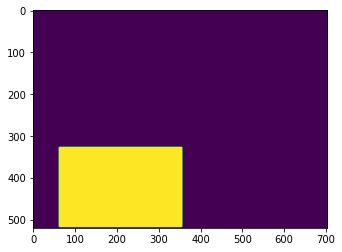

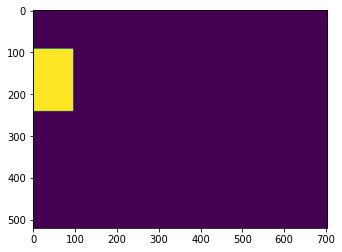

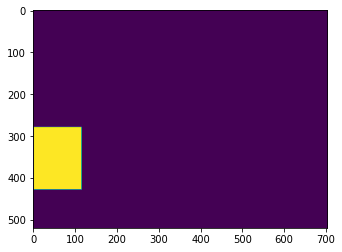

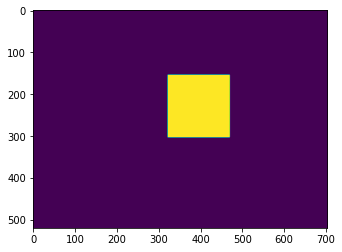

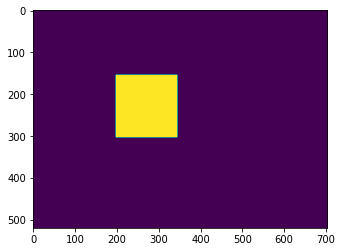

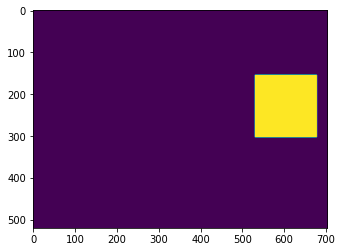

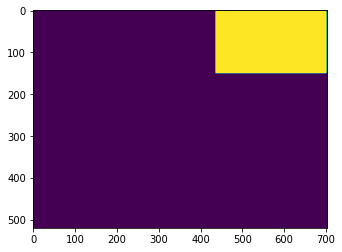

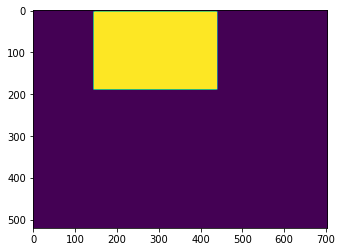

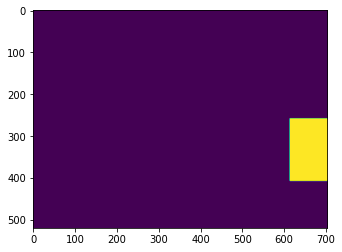

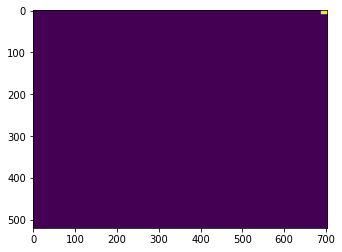

SystemExit: 0

In [75]:
model = maskrcnn_resnet50_fpn(progress=False, num_classes=2)
model.load_state_dict(torch.load(weights_dir, map_location=torch.device("cpu")))
model.to(device)
model.eval()

for image_path in test_images_dir.glob("**/*.png"):
    print(image_path.absolute())
    image = io.imread(str(image_path))
    image = preprocess_image(image=image)['image']
    image = image.to(device)

    with torch.no_grad():
        output = model.forward([image])[0]

    print(output)
    scores = output['scores'].detach().cpu()
    masks = output['masks'].squeeze().detach().cpu()
    boxes = output['boxes'].detach().cpu()

    print(f"found {len(boxes)} instances!")

    masks = (masks >= mask_threshold).int()

    # Now some masks can be empty (all zeros), we need to exclude them
    indices = torch.as_tensor([torch.sum(mask) > 0 for mask in masks])
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    print(f"After mask thresholding survived {len(masks)} instances")

    indices = scores >= score_threshold
    masks, boxes, scores = masks[indices], boxes[indices], scores

    print(f"After confidence thresholding survived {len(masks)} instances")

    indices = nms(boxes, scores, nms_threshold)
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]


    print(f"Finally survived {len(masks)} instances! Displaying them...")


    # Display masks
    for ii in range(10):
        plt.imshow(masks[ii])
        plt.show()

    # display_masks(image, masks)

    sys.exit(0)

